# ChatGPT’s svar på caset:

[                       0%                       ][**********************50%                       ]  2 of 4 completed[**********************75%***********            ]  3 of 4 completed[*********************100%***********************]  4 of 4 completed

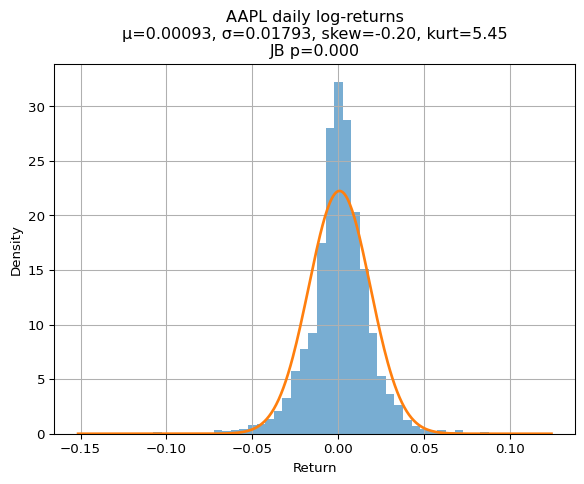

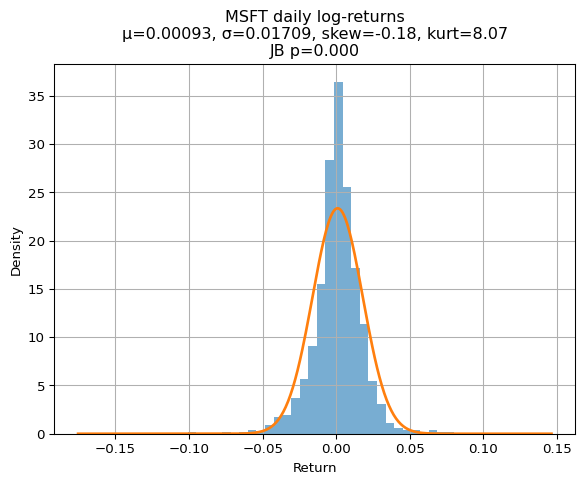

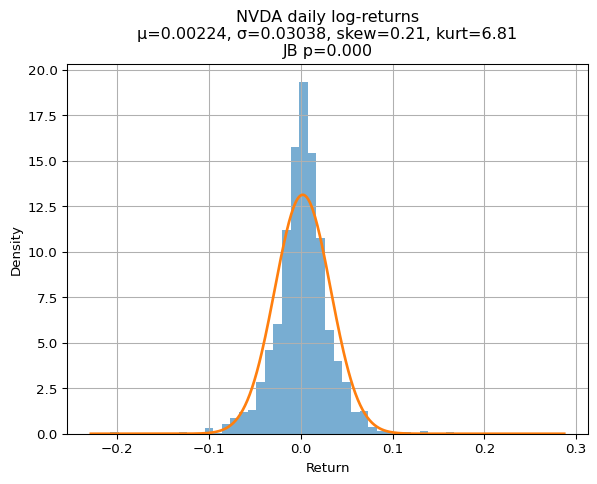

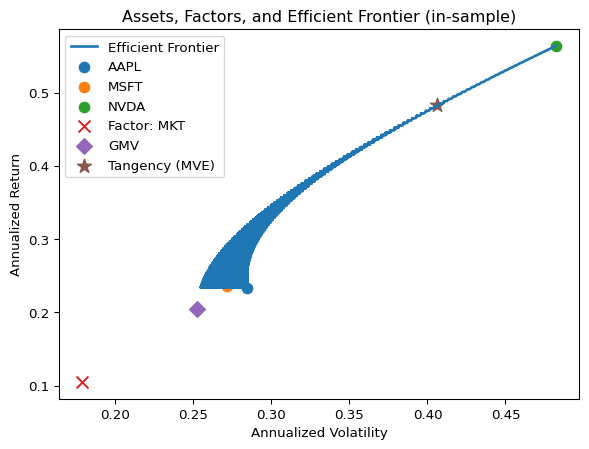

Risk-averse mix: risky weight = 0.24604169696655698 Return= 0.14156495357227625 Vol= 0.1
Risk-seeking mix: risky weight = 0.7381250908996709 Return= 0.3646948607168287 Vol= 0.3
   Model  Alpha       VaR  Exceed   N     Rate  Kupiec p  Christoffersen p
 Hist_99   0.99  0.066875       5 181 0.027624  0.000000          0.109934
 Norm_99   0.99 -0.061480     179 181 0.988950  0.888991          0.832106
StudT_99   0.99 -0.073337     180 181 0.994475  0.508573          0.915818
 EWMA_99   0.99 -0.041723     175 181 0.966851  0.013519          0.173287
 Hist_95   0.95  0.038785      12 181 0.066298  0.000000          0.816699
 Norm_95   0.95 -0.044032     177 181 0.977901  0.053922          0.669802

/var/folders/q2/8w2n22tj35v95srlf90nqd440000gp/T/ipykernel_22136/2673897486.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a,b = h[i-1], h[i]
/var/folders/q2/8w2n22tj35v95srlf90nqd440000gp/T/ipykernel_22136/2673897486.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a,b = h[i-1], h[i]
/var/folders/q2/8w2n22tj35v95srlf90nqd440000gp/T/ipykernel_22136/2673897486.py:217: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a,b = h[

In [1]:
# --- Setup ---
import numpy as np, pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from itertools import product

# Optional: from arch import arch_model

# ===== User inputs =====
TICKERS = ["AAPL", "MSFT", "NVDA"]  # BYTT til dine 3 aksjer
MARKET_TICKER = "^GSPC"             # BYTT til marked (OSEBX: "^OSEAX" / "^OSEBX" i Yahoo varierer)
FACTOR_PROXIES = {
    "MKT": MARKET_TICKER,
    # legg til andre faktorer om ønskelig, f.eks. "ENERGY": "^SP500-15" (eller sektor-ETF)
}
risk_free_annual = 0.03  # BYTT til din risikofrie rente (annualisert); blir daglig under
INSAMPLE_END = "2024-12-31"
START_DATE = "2015-01-01"  # eller tidligere om tilgjengelig
OOS_START = "2025-01-01"
TODAY = datetime.today().strftime("%Y-%m-%d")

# ===== Download data =====
tickers_all = list(set(TICKERS + list(FACTOR_PROXIES.values())))
px = yf.download(tickers_all, start=START_DATE, end=TODAY, auto_adjust=True)["Close"].dropna(how="all")
px = px.dropna()
ret = np.log(px).diff().dropna()

# Align assets & factors
assets = ret[TICKERS].dropna()
factors = pd.concat({k: ret[v] for k,v in FACTOR_PROXIES.items()}, axis=1).dropna()
common = assets.index.intersection(factors.index)
assets = assets.loc[common]
factors = factors.loc[common]

# Split in-sample / out-of-sample
ins = slice(assets.index.min(), INSAMPLE_END)
oos = slice(OOS_START, assets.index.max())

assets_in = assets.loc[ins].dropna()
assets_oos = assets.loc[oos].dropna()

factors_in = factors.loc[ins].dropna()
factors_oos = factors.loc[oos].dropna()

# Risk-free daily
trading_days = 252
rf_daily = (1 + risk_free_annual)**(1/trading_days) - 1

# ===== 1) Histograms + normal overlay =====
def plot_hist_norm(series, name):
    mu, sigma = series.mean(), series.std(ddof=1)
    jb = stats.jarque_bera(series)
    fig = plt.figure()
    series.hist(bins=50, density=True, alpha=0.6)
    xs = np.linspace(series.min()*1.1, series.max()*1.1, 400)
    plt.plot(xs, stats.norm.pdf(xs, mu, sigma), lw=2)
    plt.title(f"{name} daily log-returns\nμ={mu:.5f}, σ={sigma:.5f}, skew={stats.skew(series):.2f}, kurt={stats.kurtosis(series, fisher=True):.2f}\nJB p={jb.pvalue:.3f}")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.show()

for col in assets_in:
    plot_hist_norm(assets_in[col], col)

# ===== 2) Efficient frontier =====
mu = assets_in.mean()*trading_days         # annualized mean
Sigma = assets_in.cov()*trading_days       # annualized covariance
ones = np.ones(len(TICKERS))

# Global Minimum Variance (GMV)
Sigma_inv = np.linalg.pinv(Sigma.values)
w_gmv = (Sigma_inv @ ones) / (ones @ Sigma_inv @ ones)

# Tangency (MVE) with rf
excess = mu.values - risk_free_annual*ones
w_tan_unscaled = Sigma_inv @ excess
w_tan = w_tan_unscaled / (ones @ w_tan_unscaled)  # sum to 1 within risky assets
mu_tan = float(w_tan @ mu.values)
sig_tan = float(np.sqrt(w_tan @ Sigma.values @ w_tan))

# Frontier (long-only or allow shorts)
def efficient_frontier(mu, Sigma, n=200, allow_shorts=False):
    mu = mu.values; S = Sigma.values
    if allow_shorts:
        # grid target returns across [min, max]
        r_targets = np.linspace(mu.min(), mu.max(), n)
        W = []
        for r in r_targets:
            # solve min w'Sw s.t. w'1=1, w'μ=r
            A = np.block([[2*S, ones[:,None], mu[:,None]],
                          [ones[None,:], np.zeros((1,2))],
                          [mu[None,:],  np.zeros((1,2))]])
            b = np.r_[np.zeros(len(mu)), 1, r]
            sol = np.linalg.lstsq(A, b, rcond=None)[0]
            w = sol[:len(mu)]
            W.append((r, np.sqrt(w@S@w), w))
        return pd.DataFrame([(r, s) for r,s,_ in W], columns=["ret","risk"]), W
    else:
        # grid weights on simplex
        from itertools import product
        m = len(mu); grid = np.linspace(0,1,101)
        W = []
        for w in product(grid, repeat=m):
            w = np.array(w)
            if abs(w.sum()-1)<1e-9:
                r = w@mu; s = np.sqrt(w@Sigma.values@w)
                W.append((r,s,w))
        df = pd.DataFrame(W, columns=["ret","risk","w"])
        # keep lower envelope
        df = df.sort_values("risk")
        hull = df[df["ret"]==df.groupby("risk")["ret"].transform("max")]
        return hull[["ret","risk"]], [(r,s,w) for r,s,w in zip(hull["ret"], hull["risk"], hull["w"])]

front_df, Wlist = efficient_frontier(mu, Sigma, allow_shorts=False)

# Plot assets, factors, frontier, GMV, Tangency
plt.figure()
plt.plot(front_df["risk"], front_df["ret"], lw=2, label="Efficient Frontier")
for a in mu.index:
    plt.scatter(np.sqrt(Sigma.loc[a,a]), mu[a], s=60, label=a)
# Factors (annualized)
f_mu = factors_in.mean()*trading_days
f_sig = (factors_in.std()*np.sqrt(trading_days))
for f in f_mu.index:
    plt.scatter(f_sig[f], f_mu[f], marker="x", s=80, label=f"Factor: {f}")
plt.scatter(np.sqrt(w_gmv @ Sigma.values @ w_gmv), w_gmv @ mu.values, marker="D", s=70, label="GMV")
plt.scatter(sig_tan, mu_tan, marker="*", s=120, label="Tangency (MVE)")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.legend()
plt.title("Assets, Factors, and Efficient Frontier (in-sample)")
plt.show()

# ===== 3) Optimal portfolios for two investor-typer =====
# Risikoavers (mål: lav sigma, på CML mellom rf og tangens)
target_sigma_risk_averse = 0.10  # BYTT terskel
weight_risky = min(1.0, target_sigma_risk_averse / sig_tan)
w_ra = weight_risky * w_tan  # resten i risikofri
mu_ra = risk_free_annual*(1-weight_risky) + weight_risky*mu_tan
sig_ra = weight_risky*sig_tan

# Risikosøkende (tillat gearing opp langs CML)
target_sigma_risk_seeking = 0.30  # BYTT terskel
weight_risky_rs = target_sigma_risk_seeking / sig_tan
w_rs = weight_risky_rs * w_tan  # kan være >1 (låne risikofri)
mu_rs = risk_free_annual*(1-weight_risky_rs) + weight_risky_rs*mu_tan
sig_rs = weight_risky_rs*sig_tan

print("Risk-averse mix: risky weight =", weight_risky, "Return=", mu_ra, "Vol=", sig_ra)
print("Risk-seeking mix: risky weight =", weight_risky_rs, "Return=", mu_rs, "Vol=", sig_rs)

# ===== 4) VaR models (1-day, 95%/99%) on in-sample portfolio (use tangency portfolio as example) =====
def portfolio_returns(w, R):
    return (R @ w).rename("p")

p_in = portfolio_returns(w_tan, assets_in)

def var_historical(x, alpha=0.99):
    return -np.quantile(x, 1-alpha)

def var_normal(x, alpha=0.99):
    mu, sigma = x.mean(), x.std(ddof=1)
    z = stats.norm.ppf(alpha)
    return -(mu + z*sigma)

def var_student_t(x, alpha=0.99):
    params = stats.t.fit(x)  # df, loc, scale
    df, loc, scale = params
    q = stats.t.ppf(alpha, df, loc=loc, scale=scale)
    return -q

def var_ewma(x, alpha=0.99, lam=0.94):
    x = x.values
    var = np.zeros_like(x)
    var[0] = np.var(x[:50])
    for t in range(1,len(x)):
        var[t] = lam*var[t-1] + (1-lam)*x[t-1]**2
    z = stats.norm.ppf(alpha)
    # last variance as forecast
    return -(x.mean() + z*np.sqrt(var[-1]))

VaR_models = {
    "Hist_99": lambda s: var_historical(s, 0.99),
    "Norm_99": lambda s: var_normal(s, 0.99),
    "StudT_99": lambda s: var_student_t(s, 0.99),
    "EWMA_99": lambda s: var_ewma(s, 0.99),
    "Hist_95": lambda s: var_historical(s, 0.95),
    "Norm_95": lambda s: var_normal(s, 0.95),
}

in_sample_VaR = {k: f(p_in) for k,f in VaR_models.items()}
pd.Series(in_sample_VaR).to_frame("1d VaR (in-sample)").style.format("{:.5f}")

# ===== 5) Backtesting (Kupiec & Christoffersen) on out-of-sample =====
p_oos = portfolio_returns(w_tan, assets_oos)
def hit_series(x, VaR):
    # exceedance when loss > VaR  (x negative)
    return (x < -VaR).astype(int)

def kupiec_pof(h, alpha):
    n = len(h); x = h.sum()
    pi_hat = x/n
    # Likelihood ratio
    L0 = (1-alpha)**(n-x) * alpha**x
    L1 = (1-pi_hat)**(n-x) * (pi_hat**x if pi_hat>0 else 1)
    LR = -2*np.log(L0/L1) if L0>0 and L1>0 else np.inf
    pval = 1 - stats.chi2.cdf(LR, df=1)
    return x, n, pi_hat, LR, pval

def christoffersen_independence(h):
    # counts of transitions
    h = h.astype(int)
    n00=n01=n10=n11=0
    for i in range(1,len(h)):
        a,b = h[i-1], h[i]
        if a==0 and b==0: n00+=1
        if a==0 and b==1: n01+=1
        if a==1 and b==0: n10+=1
        if a==1 and b==1: n11+=1
    pi0 = n01/max(n00+n01,1)
    pi1 = n11/max(n10+n11,1)
    pi = (n01+n11)/max(n00+n01+n10+n11,1)
    # LR_ind
    L0 = ((1-pi)**(n00+n10))*(pi**(n01+n11))
    L1 = ((1-pi0)**n00)*(pi0**n01)*((1-pi1)**n10)*(pi1**n11)
    LR = -2*np.log(L0/L1) if L0>0 and L1>0 else np.inf
    pval = 1 - stats.chi2.cdf(LR, df=1)
    return {"n00":n00,"n01":n01,"n10":n10,"n11":n11,"LR":LR,"pval":pval}

def backtest_table(p_oos, alpha_list=(0.95,0.99)):
    rows=[]
    for name, f in VaR_models.items():
        # infer alpha from name
        alpha = 0.99 if "99" in name else 0.95
        VaR_hat = f(p_in)  # fixed from in-sample (one-step naive)
        h = hit_series(p_oos, VaR_hat)
        x,n,pi_hat,LR,pval = kupiec_pof(h, alpha)
        indep = christoffersen_independence(h)
        rows.append([name, alpha, VaR_hat, x, n, x/n, pval, indep["pval"]])
    return pd.DataFrame(rows, columns=["Model","Alpha","VaR","Exceed","N","Rate","Kupiec p","Christoffersen p"])

bt = backtest_table(p_oos)
print(bt.to_string(index=False))

# (Valgfritt) rullerende re-estimering kan implementeres for strengere backtest.
